In [66]:
from typing_extensions import TypedDict
from typing import Dict, List,Any
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage,AnyMessage,BaseMessage
from langgraph.graph import StateGraph,START,END
# from langgraph.checkpoint.redis import RedisSaver
from IPython.display import Image,display
from typing import Annotated 
from typing import Any
import operator
import json
import os
import re
from dotenv import load_dotenv
load_dotenv()
# tools
from Tools.Doc_QnA_RAG import rag_qa_tool
from Tools.News import financial_news_search
from Tools.general_qna import gen_qna
from Tools.Image_qna import image_qna
from Tools.refiner import ContentRefiner
from Tools.prompt import ROUTER_PROMPT

In [67]:
from mem0 import MemoryClient
memory = MemoryClient()

In [68]:
class GraphState(TypedDict, total=False):
    input: str
    uploaded_doc : str
    uploaded_img : str
    agent_order: List[Dict[str,str]]
    routing_reasoning : str      
    current_agent_index : int
    processed_agents : List[str]        
    agent_outputs: Dict[str, str]  
    messages_added : bool     
    final_response: str
    user_id : str
    session_id : str
    messages: Annotated[List[AnyMessage], operator.add] 
    past_memory : str

In [69]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0, google_api_key=os.getenv("GOOGLE_API_KEY"))


In [70]:
def format_history(history: List[BaseMessage]) -> str:
        """Format message history into a string for model input."""
        formatted = ""
        for msg in history[-5:]:
            role = "User" if isinstance(msg, HumanMessage) else "Assistant"
            formatted += f"{role}: {msg.content}\n"
        return formatted.strip()

In [71]:
def load_memory(state: GraphState) -> GraphState:
    """
    Loads summarized memory and full conversation (if stored) for the given user/session
    from Mem0, and prepares messages for router usage.
    """
    user_id = state.get("user_id")
    session_id = state.get("session_id")

    all_memories = memory.get_all(user_id=user_id)

    if not all_memories:
        state["past_memory"] = "This is a fresh conversation"
        return  state

    session_memories = [m for m in all_memories if m.get("metadata", {}).get("session_id") == session_id]

    summaries = [m.get("memory", "") for m in session_memories]
    
    full_convos = []
    for mem in session_memories:
        convo = mem.get("metadata", {}).get("full_conversation", [])
        for msg in convo:
            if msg["role"] == "user":
                full_convos.append(HumanMessage(content=msg["content"]))
            elif msg["role"] == "assistant":
                full_convos.append(AIMessage(content=msg["content"]))

    combined_context = "\n\n".join([
        "Summarized memory:\n" + "\n".join(summaries),
        "Recent conversation:\n" + "\n".join([msg.content for msg in full_convos[-10:]])  # last 20 messages
    ])

    state["past_memory"] = combined_context
    return state

In [72]:
def Router(state: GraphState) -> GraphState:
    try:
        query = state["input"]      
        previous_memory = state.get("past_memory", "")

        history = format_history(state["messages"][-10:])

        final_query = f"User Query: {query}\n\n Conversation History:\n{history}\n\n Summarized Memory:\n{previous_memory}\n"

        # print("query received") 
        messages = [
            SystemMessage(content=ROUTER_PROMPT),
            HumanMessage(content=f"Query: {final_query}")
        ]
        # print("query structured")
        
        response = llm.invoke(messages)
        raw = response.content.strip()
        if raw.startswith("```"):
            raw = re.sub(r"^```[a-z]*\n?", "", raw)
            raw = re.sub(r"\n?```$", "", raw)

        # print(response.content)
        # print("response generated")
        parsed = json.loads(raw)
        # parsed = json.loads(response.content)
        # print("response parsed!")
        # print(parsed)
        
        agents = parsed.get("agents", [
            {
            "name": "General_qna",
            "query": f"{query}",
            "dependencies": []
        }
        ])
        reasoning = parsed.get("reasoning", "Default routing")
        
        valid_agents = [agent for agent in agents]
    
        if not valid_agents:
            valid_agents = [
            {
            "name": "General_qna",
            "query": f"{query}",
            "dependencies": []
            }
        ]
        state["agent_order"] = valid_agents
        state["routing_reasoning"] = reasoning
        state["agent_outputs"] = {}
        state["processed_agents"] = []
        state["current_agent_index"] = 0          
        # print(state)
    except Exception as e:
        state["agent_order"] = [
            {
            "name": "Aggregator",
            "query": f"{query}",
            "dependencies": []
        }
        ]
        state["routing_reasoning"] = "The Router could not find any tools for this query , hence returning to Aggregator"
        state["agent_outputs"] = {}
        state["processed_agents"] = []
        state["current_agent_index"] = 0       
        print(f"Error in Routing : {e}")
        
    return state

In [73]:
def route_to_agents(state:GraphState) -> GraphState:
    agent_order = state.get("agent_order",[{
            "name": "Aggregator",
            "query": f"{state["input"]}",
            "dependencies": []
            }])
    
    if "current_agent_index" not in state:
        state["current_agent_index"] = 0

    current_index = state["current_agent_index"]

    if current_index<len(agent_order):
        agent = agent_order[current_index]["name"]
        print(f"Routing to : {agent}, current index at: {current_index}")
        return agent
    return 'Aggregator'

In [ ]:
def Document_qna(state:GraphState) -> GraphState:
    try:
        query = state["agent_order"][state["current_agent_index"]]["query"]
        dependencies_list = state["agent_order"][state["current_agent_index"]]["dependencies"]

        dependencies_context = ""
        if dependencies_list:
            for dep in dependencies_list:
                if dep in state["agent_outputs"]:
                    dep_output = state["agent_outputs"][dep]
                    dependencies_context+= f"Dependency : {dep} ouput: {dep_output}"
                else:
                    print(f"Dependency {dep} output not found in agent_outputs")      

        history = state["messages"][:-10]        
        # print(query)
        uploaded_doc_path = state["uploaded_doc"]
        # print(uploaded_doc_path)
        result  = rag_qa_tool.invoke({
            "file_path": uploaded_doc_path,
            "query": query,
            "dependency_context": dependencies_context,
            "message_history": history
        })
        # print(result)
        state["agent_outputs"]["Doc_QnA"] = result
        state["processed_agents"].append("Document_QnA")
        if state["current_agent_index"] + 1 <= len(state["agent_order"]):
            state["current_agent_index"] = state["current_agent_index"] + 1 
        else: 
            state["current_agent_index"] = 0

    except Exception as e:
        state["processed_agents"].append("Document_QnA")
        if state["current_agent_index"] + 1 <= len(state["agent_order"]):
            state["current_agent_index"] = state["current_agent_index"] + 1 
        else: 
            state["current_agent_index"] = 0
        print(f"Error in Doc_QnA : {e}")
    return state

In [ ]:
def News(state:GraphState) -> GraphState:
    try:
        query = state["agent_order"][state["current_agent_index"]]["query"]
        print(query)
        dependencies_list = state["agent_order"][state["current_agent_index"]]["dependencies"]
        
        dependencies_context = ""
        if dependencies_list:
            for dep in dependencies_list:
                if dep in state["agent_outputs"]:
                    dep_output = state["agent_outputs"][dep]
                    dependencies_context+= f"Dependency : {dep} ouput: {dep_output}"
                else:
                    print(f"Dependency {dep} output not found in agent_outputs")
        history = state["messages"][:-10]        

        print("entering news tool")
        result = financial_news_search.invoke({"query" : query,
                                               "dependency_context": dependencies_context,
                                               "message_history": history})
        state["agent_outputs"]["News"] = result
        state["processed_agents"].append("NEWS")
        if state["current_agent_index"] + 1 < len(state["agent_order"]):
            state["current_agent_index"] = state["current_agent_index"] + 1 
        else: 
            state["current_agent_index"] = 0
    except Exception as e:
        state["processed_agents"].append("NEWS")
        if state["current_agent_index"] + 1 <= len(state["agent_order"]):
            state["current_agent_index"] = state["current_agent_index"] + 1 
        else: 
            state["current_agent_index"] = 0
        print(f"Error in News : {e}")
    return state

In [ ]:
def General_qna(state:GraphState) -> GraphState:
    try:
        query = state["agent_order"][state["current_agent_index"]]["query"]
        dependencies_list = state["agent_order"][state["current_agent_index"]]["dependencies"]
        dependencies_context = ""
        if dependencies_list:
            for dep in dependencies_list:
                if dep in state["agent_outputs"]:
                    dep_output = state["agent_outputs"][dep]
                    dependencies_context+= f"Dependency : {dep} ouput: {dep_output}"
                else:
                    print(f"Dependency {dep} output not found in agent_outputs")
        history = state["messages"][:-10]

        result = gen_qna.invoke({"question" : query,
        "dependency_context": dependencies_context,
        "message_history": history})


        state["agent_outputs"]["General_QnA"] = result
        state["processed_agents"].append("General_QnA")
        if state["current_agent_index"] + 1 <= len(state["agent_order"]):
            state["current_agent_index"] = state["current_agent_index"] + 1 
        else: 
            state["current_agent_index"] = 0
    except Exception as e:
        state["processed_agents"].append("General_QnA")
        if state["current_agent_index"] + 1 <= len(state["agent_order"]):
            state["current_agent_index"] = state["current_agent_index"] + 1 
        else: 
            state["current_agent_index"] = 0
        print(f"Error in General_qna : {e}")
    return state

In [76]:
def Image_qna(state:GraphState) -> GraphState:
    try:
        query =state["agent_order"][state["current_agent_index"]]["query"]
        dependencies_list = state["agent_order"][state["current_agent_index"]]["dependencies"]

        dependencies_context = ""
        if dependencies_list:
            for dep in dependencies_list:
                if dep in state["agent_outputs"]:
                    dep_output = state["agent_outputs"][dep]
                    dependencies_context+= f"Dependency : {dep} ouput: {dep_output}"
                else:
                    print(f"Dependency {dep} output not found in agent_outputs")
        history = state["messages"][:-10]
    
        # print(query)
        uploaded_img = state["uploaded_img"]
        # print(uploaded_doc_path)
        response = image_qna.invoke({
            "uploaded_file": uploaded_img,
            "query": query,
            "dependency_context": dependencies_context,
            "message_history": history

        })
        state["agent_outputs"]["Image_qna"] = response
        state["processed_agents"].append("Image_qna")
        if state["current_agent_index"] + 1 <= len(state["agent_order"]):
            state["current_agent_index"] = state["current_agent_index"] + 1 
        else: 
            state["current_agent_index"] = 0
    except Exception as e:
        state["processed_agents"].append("Image_qna")
        if state["current_agent_index"] + 1 <= len(state["agent_order"]):
            state["current_agent_index"] = state["current_agent_index"] + 1 
        else: 
            state["current_agent_index"] = 0
        print(f"Error in Image_qna : {e}")
    return state

In [78]:
def Refiner(state:GraphState) -> GraphState:
    try:
        query = state["agent_order"][state["current_agent_index"]]["query"]
        dependencies_list = state["agent_order"][state["current_agent_index"]]["dependencies"]


        dependencies_context = ""
        if dependencies_list:
            for dep in dependencies_list:
                if dep in state["agent_outputs"]:
                    dep_output = state["agent_outputs"][dep]
                    dependencies_context+= f"Dependency : {dep} ouput: {dep_output}"
                else:
                    print(f"Dependency {dep} output not found in agent_outputs")
        history = state["messages"][:-10]


        result = ContentRefiner.invoke({"query" : query,
                                        "dependency_context": dependencies_context,
                                        "message_history": history})
        state["agent_outputs"]["ContentRefiner"] = result
        state["processed_agents"].append("ContentRefiner")
        if state["current_agent_index"] + 1 <= len(state["agent_order"]):
            state["current_agent_index"] = state["current_agent_index"] + 1 
        else: 
            state["current_agent_index"] = 0
    except Exception as e:
        state["processed_agents"].append("ContentRefiner")
        if state["current_agent_index"] + 1 <= len(state["agent_order"]):
            state["current_agent_index"] = state["current_agent_index"] + 1 
        else: 
            state["current_agent_index"] = 0
        print(f"Error in ContentRefiner : {e}")
    return state     

In [81]:
def Aggregator(state:GraphState) -> GraphState:
    try:
        final_agent_outputs = state["agent_outputs"]
        routing_reasoning = state.get("routing_reasoning", "")
        initial_query = state["input"]
        previous_memory = state.get("past_memory", "")
        history = format_history(state["messages"][-10:])

        if not final_agent_outputs:
            state["final_response"] = "No agent outputs to aggregate."
            return state
        
        if len(final_agent_outputs) == 1:
            _,response = next(iter(final_agent_outputs.items()))
            state["final_response"] = response

        else:
            aggregation_prompt = f"""
                        You are an expert output aggregator. along with the intial query you maybe given the responses from the tools, previous conversation history and past memories related to the user, Combine them into a coherent, comprehensive answer , also if needed take into consideration the previous converstation history to answer the initial_query.
                        
                        initial query : {initial_query}
                        Routing reasoning: {routing_reasoning}
                        
                        Responses:
                        {json.dumps(final_agent_outputs, indent=2)}


                        Conversation history: {history}

                        past memories : {previous_memory}
                        Create a unified response that integrates insights from all the responses and the conversation history if needed, while avoiding redundancy.
            
                        """
            messages = [
                SystemMessage(content="You are an expert at synthesizing information from multiple sources."),
                HumanMessage(content=aggregation_prompt)
            ]
            
            response = llm(messages)
            state["final_response"] = response.content

    except Exception as e:
        print(f"Error in Aggregation : {e}")

        
    return state

In [87]:
def save_memory(state: GraphState) -> GraphState:
    """
    Save the user input and final AI response to memory, including full conversation metadata.
    Should be called after final response is generated.
    """
    user_id = state.get("user_id")
    session_id = state.get("session_id")
    user_message = state.get("input")
    ai_response = state.get("final_response")

    if user_message and ai_response:
        # messages = [
        #     {"role": "user", "content": user_message},
        #     {"role": "assistant", "content": ai_response}
        # ]
        # Save user+AI messages as metadata field "full_conversation"
        result = memory.add(
            [{"role": "user", "content": user_message},
             {"role": "assistant","content":ai_response}],  # minimal "memory" entry
            user_id=user_id,
            metadata={
                "session_id": session_id,
                # "full_conversation": messages
            }
        )
        print(f"Memory saved to Mem0: {result}")
    else:
        print("Missing user message or AI response; not saving memory.")

    return state


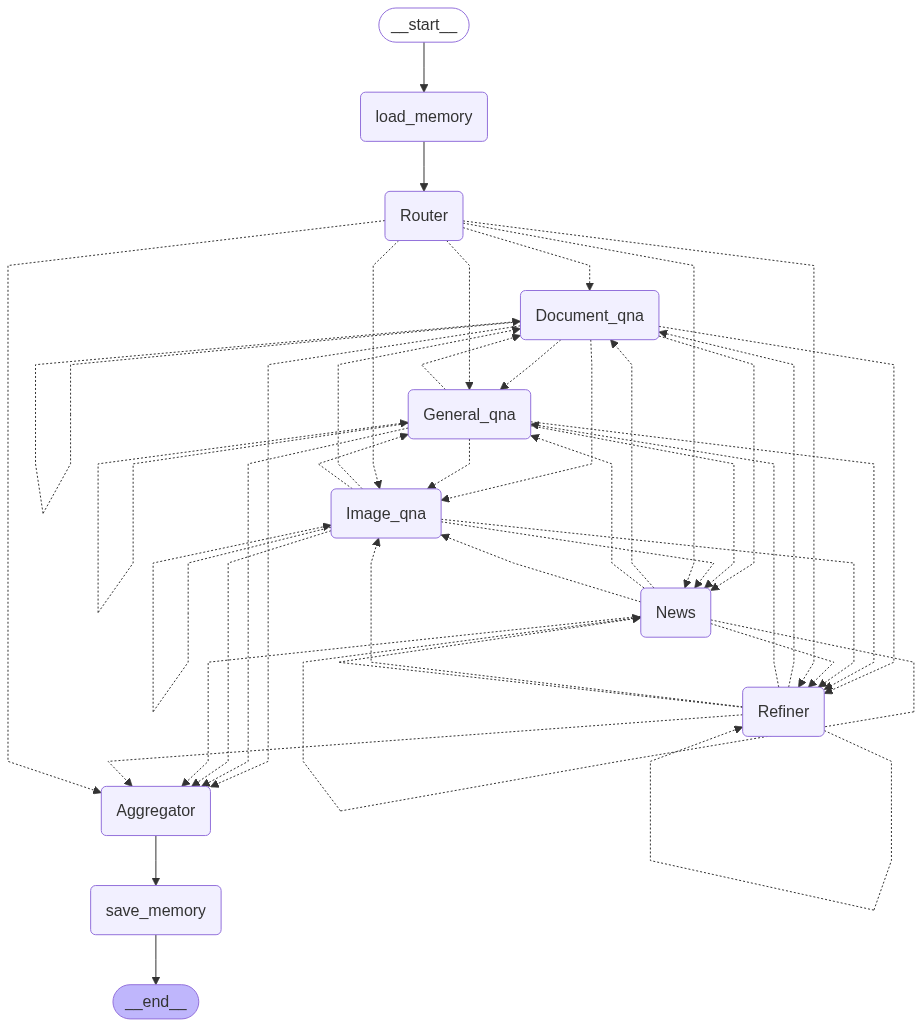

In [90]:


builder = StateGraph(GraphState)

builder.add_node("load_memory",load_memory)
builder.add_node("Router", Router)
builder.add_node("Document_qna", Document_qna)
builder.add_node("General_qna", General_qna)
builder.add_node("News", News)
builder.add_node("Refiner",Refiner)

builder.add_node("Image_qna", Image_qna)
builder.add_node("Aggregator", Aggregator)

builder.add_node("save_memory", save_memory)



# builder.set_entry_point("load_memory")

builder.add_edge(START,"load_memory")
builder.add_edge("load_memory","Router")

tool_names = ["Document_qna", "General_qna", "News","Image_qna" ,"Refiner","Aggregator"]

routing_map = {
    'Document_qna': 'Document_qna',
    'General_qna': 'General_qna',
    'News': 'News',
    "Image_qna" : "Image_qna",
    "Refiner" : "Refiner",
    'Aggregator': 'Aggregator'
}

builder.add_conditional_edges("Router", route_to_agents,routing_map)

builder.add_conditional_edges("Document_qna", route_to_agents, routing_map)

builder.add_conditional_edges("General_qna", route_to_agents,routing_map)

builder.add_conditional_edges("News", route_to_agents, routing_map)

builder.add_conditional_edges("Image_qna", route_to_agents, routing_map)

builder.add_conditional_edges("Refiner", route_to_agents, routing_map)

builder.add_edge("Aggregator", "save_memory")

builder.add_edge("save_memory", END)

graph = builder.compile()



from IPython.display import Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [89]:
query= "summarize the given documen also tell me what is the given image , and what is the latest news on the company mentioned in the given image also explain blockchain"
initial_state = {
        "input": query,
        "uploaded_doc" : "/home/saikrishnanair/Downloads/2PageNvidia.pdf",
        "uploaded_img" : "/home/saikrishnanair/balancesheet.png",
        "agent_order": [],
        "routing_reasoning" : "",
        "current_agent_index": 0,
        "processed_agents": [],
        "agent_outputs": {},
        "final_response": "",
        "messages" : [],
        "user_id" : "user_001",
        "session_id" : "session_001",
        "past_memory" : ""
    }

result = graph.invoke(initial_state)
import pprint
pprint.pprint(result)

Routing to : Document_qna, current index at: 0
Original Query: Summarize the document.
Dependency Context: 

Refined query: Summarize the document.
Loading cached FAISS index for file hash 18e5e8c3d87123ab981ad67df8c8cf1c...
Loaded cached vector store successfully.
Routing to : Image_qna, current index at: 1


/home/saikrishnanair/anaconda3/lib/python3.12/site-packages/botocore/auth.py:422: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  datetime_now = datetime.datetime.utcnow()


Refined query: Describe the content of the image.
Routing to : News, current index at: 2
What is the latest news on the company mentioned in the image?
entering news tool
news tool invoked
Optimized search query: "Apple Inc. financial news balance sheet analysis"
Routing to : General_qna, current index at: 3


/home/saikrishnanair/anaconda3/lib/python3.12/site-packages/mem0/client/main.py:34: DeprecationWarning: output_format='v1.0' is deprecated therefore setting it to 'v1.1' by default. Check out the docs for more information: https://docs.mem0.ai/platform/quickstart#4-1-create-memories
  return func(*args, **kwargs)


Memory saved to Mem0: {'results': []}
{'agent_order': [{'dependencies': [],
                  'name': 'Document_qna',
                  'query': 'Summarize the document.'},
                 {'dependencies': [],
                  'name': 'Image_qna',
                  'query': 'Describe the content of the image.'},
                 {'dependencies': ['Image_qna'],
                  'name': 'News',
                  'query': 'What is the latest news on the company mentioned '
                           'in the image?'},
                 {'dependencies': [],
                  'name': 'General_qna',
                  'query': 'Explain blockchain.'}],
 'agent_outputs': {'Doc_QnA': 'NVIDIA reported record revenue for fiscal year '
                              '2025, with $130.5 billion, up 114% from the '
                              'previous year. GAAP earnings per diluted share '
                              'were $2.94, a 147% increase year-over-year, '
                              'w

In [56]:
query= "give me a two line summary"
initial_state = {
        "input": query,
        "uploaded_doc" : "/home/saikrishnanair/Downloads/2PageNvidia.pdf",
        "uploaded_img" : "/home/saikrishnanair/balancesheet.png",
        "agent_order": [],
        "routing_reasoning" : "",
        "current_agent_index": 0,
        "processed_agents": [],
        "agent_outputs": {},
        "final_response": "",
        "user_id" : "test_user_123",
        "session_id" : "test_session_456",
        "past_memory" : ""
    }

result = graph.invoke(initial_state)
import pprint
pprint.pprint(result)

{'input': 'give me a two line summary', 'uploaded_doc': '/home/saikrishnanair/Downloads/2PageNvidia.pdf', 'uploaded_img': '/home/saikrishnanair/balancesheet.png', 'agent_order': [{'name': 'Refiner', 'query': "Summarize the following information about Apple Inc.'s Consolidated Balance Sheets for September 26, 2020, and September 28, 2019 in two lines: Total Shareholders' Equity in 2020 was $65.339 million and in 2019 was $90.488 million. Total Liabilities in 2020 were $258.549 million and in 2019 were $248.028 million. Total Assets in 2020 were $323.888 million and in 2019 were $338.516 million.", 'dependencies': []}], 'routing_reasoning': "The query asks for a two-line summary. Based on the summarized memory, the user has been asking about the content of a given image, which contains information about Apple Inc.'s Consolidated Balance Sheets. The Refiner agent is used to summarize the provided information in two lines.", 'current_agent_index': 0, 'processed_agents': [], 'agent_outputs'

/home/saikrishnanair/anaconda3/lib/python3.12/site-packages/mem0/client/main.py:34: DeprecationWarning: output_format='v1.0' is deprecated therefore setting it to 'v1.1' by default. Check out the docs for more information: https://docs.mem0.ai/platform/quickstart#4-1-create-memories
  return func(*args, **kwargs)


Memory saved to Mem0: {'results': []}
{'agent_order': [{'dependencies': [],
                  'name': 'Refiner',
                  'query': 'Summarize the following information about Apple '
                           "Inc.'s Consolidated Balance Sheets for September "
                           '26, 2020, and September 28, 2019 in two lines: '
                           "Total Shareholders' Equity in 2020 was $65.339 "
                           'million and in 2019 was $90.488 million. Total '
                           'Liabilities in 2020 were $258.549 million and in '
                           '2019 were $248.028 million. Total Assets in 2020 '
                           'were $323.888 million and in 2019 were $338.516 '
                           'million.'}],
 'agent_outputs': {'ContentRefiner': "In 2020, Apple's total shareholders' "
                                     'equity decreased to $65.339 million, '
                                     'while total liabilities increa

In [55]:
1. 

1.0